---

# Advanced Exercises

The following exercises might not be addressed during the course. 

They are examples that show how one can extend our simple tools to investigate and better understand more complex systems.

> **DISCLAIMER:** The notation in these exercises might not be fully consistent with previous ones. This notebook is still work in progress...

---

In [1]:
# Import custom tracking functions and useful libraries
from tracking_library import *

# Set up plotting
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

---

## Optics matching

---

### Exercise 28

A common task when designing accelerators is matching one section of a beam line
to another one. 

Assume to have an upstream beam line that consists of **5 FODO cells with a $60^o$ phase advance** and the downstream beam line of **5 FODO cells with a $90^o$ phase advance.** Assume each cell has $L_{FODO}=2$ m.  

In between the $60^o$ and $90^o,$ place a third cell (total $L=4$ m, for example) with two independent quadrupoles (they might be both focusing or defocusing) that will be used to match the upstream to the downstream beam line.
To do so, we need to prepare periodic beam matrices sigma60 and sigma90 for the respective sections. Note that sigma90 only depends on two parameters: the Twiss parameters $\alpha$ and $\beta,$ and therefore we 
also need two quadrupoles with independently variable focal length to adjust until the final beam matrix equals sigma90.

1. Implement the procedure described in the previous paragraph and match of the FODO lattice with $\mu$=60 deg and the following one with $\mu$=90 deg.
2. Plot the evolution of the sigma matrix elements along the whole beam line (5 FODO cells with $60^o$ phase advance, matching section, 5 FODO cells with $90^o$ phase advance)

**Hint:** This is a tricky exercise. Start with some matching by hand (eventually using interactive plots), then you can try to use some numerical optimiser, e.g. `from scipy.optimize import minimize`


#### SOLUTION

In [2]:
# code here your solution...
# create two FODO cells with the desired phase advances
L_2 = 2
desired_mu_1 = np.pi/3
desired_mu_2 = np.pi/2

# compute phase advance
f_1 = L_2/(4*np.sin(desired_mu_1/2))
f_2 = L_2/(4*np.sin(desired_mu_2/2))
L = L_2/2

# fodo starting from the middle of a drift
fodo_lattice_1 = 5*D(L/10) + Q(f_1) + 10*D(L/10) + Q(-f_1) + 5*D(L/10)
fodo_lattice_2 = 5*D(L/10) + Q(f_2) + 10*D(L/10) + Q(-f_2) + 5*D(L/10)

In [3]:
# for each fodo lattice, extract the closed Twiss parameters and build the corresponding sigma matrix
tune, beta, alpha, gamma = twiss(fodo_lattice_1)
sigma_60 = np.array([[beta, -alpha],[-alpha, gamma]])

tune, beta, alpha, gamma = twiss(fodo_lattice_2)
sigma_90 = np.array([[beta, -alpha],[-alpha, gamma]])

In [4]:
# optimization by hand 
L_matching = 2
def plotIt(f1, f2):
    #prepare the sigma matrix
    matching_lattice = Q(f1) + 10*D(L_matching/10) + Q(f2) + 10*D(L_matching/10)
    output_b = transportSigmas(sigma_60, 5*fodo_lattice_1 + matching_lattice + 5*fodo_lattice_2)
    
    plt.figure(figsize=(15,6))
    plt.subplot(311)
    plt.plot(output_b['s'], output_b['sigma11'], '-b', lw=3)
    plt.ylabel('sigma11')
    plt.grid(True)
    plt.subplot(312)
    plt.plot(output_b['s'], output_b['sigma22'], '-r', lw=3)
    plt.ylabel('sigma22')
    plt.grid(True)
    plt.subplot(313)    
    plt.plot(output_b['s'], output_b['sigma12'], '-k', lw=3)
    plt.ylabel('sigma12')
    plt.grid(True)
    
interactive_plot = interactive(plotIt,f1=(0,2,.1),f2=(0,2,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='f1', max=2.0), FloatSlider(value=1.0, description='f…

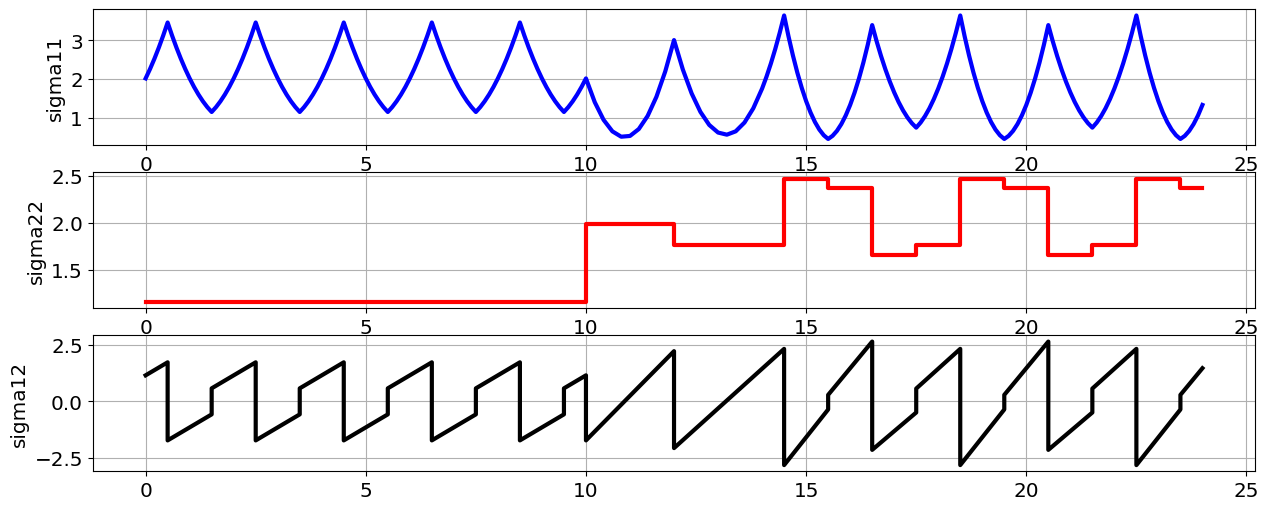

In [5]:
# It turns out that two quad with f=0.7 do the job (more or less)
f1 = 0.7
f2 = 0.7
plotIt(f1, f2)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 3.7426018393235105e-08
        x: [ 6.445e-01  7.016e-01]
      nit: 22
      jac: [ 7.508e+00  2.103e+01]
 hess_inv: [[ 2.627e-09  1.525e-10]
            [ 1.525e-10  1.788e-09]]
     nfev: 186
     njev: 58
Actual values are: f1=0.644 and f2=0.702


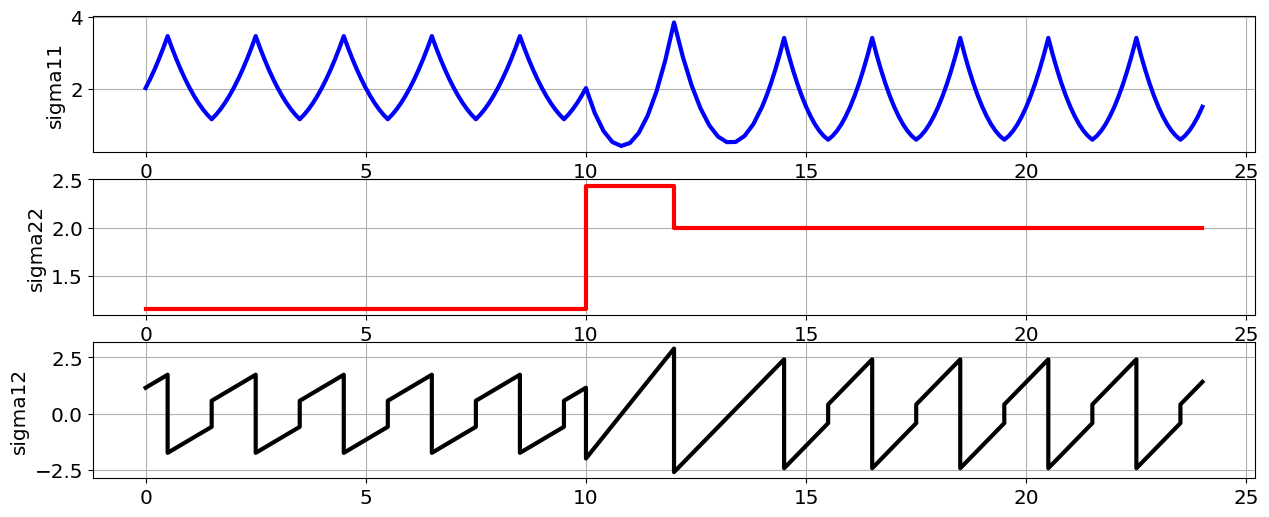

In [6]:
# let's try to use numerical optimisation using scipy.optimize package
from scipy.optimize import minimize
def penalty_function(f):
    matching_lattice = Q(f[0]) + 10*D(L_matching/10) + Q(f[1]) + 10*D(L_matching/10)
    fodo_lattice_compressed = getEquivalentElement(matching_lattice)
    M = fodo_lattice_compressed[0]['matrix']@sigma_60@(fodo_lattice_compressed[0]['matrix']).transpose() - sigma_90
    return np.linalg.norm(M)

res = minimize(penalty_function, [f1, f2])
print(res)

f1 = res['x'][0]
f2 = res['x'][1]
plotIt(f1, f2)
print(f"Actual values are: f1={f1:.3f} and f2={f2:.3f}")

---

## Thick quadrupoles and bends

---

### Exercise 29 

Introduce as a new element the thick quadrupoles matrices.

**Hint**:  write an external function that returns the corresponding list.

#### SOLUTION

In [7]:
def Qthick(k1, l):
    '''Returns a thick quadrupole element'''
    if k1>0:
        matrix = np.array([[np.cos(np.sqrt(k1)*l), 
                          1/np.sqrt(k1)*np.sin(np.sqrt(k1)*l)],
                          [-np.sqrt(k1)*np.sin(np.sqrt(k1)*l), 
                          np.cos(np.sqrt(k1)*l)]])
    else:
        k1 = -k1
        matrix = np.array([[np.cosh(np.sqrt(k1)*l),
                          1/np.sqrt(k1)*np.sinh(np.sqrt(k1)*l)],
                          [np.sqrt(k1)*np.sinh(np.sqrt(k1)*l),
                          np.cosh(np.sqrt(k1)*l)]])
    return  [{'matrix': matrix, 'length': l}]

### Exercise 30

Use the beam line from Exercise 27 (60 degrees/cell FODO) and replace the thin quadrupoles by long quadrupoles with a length of 0.2, 0.4, 1.0 m.  Make sure the overall length and the phase advance of the FODO cell remains unchanged. By how much does the periodic beta function at the start of the cell change? Express the change in percent. 

#### SOLUTION

In [8]:
# Thin lens
f = 2
L_2 = 2
fodo_lattice = Q(f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/(10))
tune, beta, alpha, gamma = twiss(fodo_lattice)
beta_thin = beta

# Thick lenses
for l_quad in [.2, .4, 1.0]:
    l_cell = 4 
    l_drift = (l_cell-2*l_quad)/2
    k1 = 1/f/l_quad
    fodo_lattice = Qthick(k1,l_quad)+10*D(l_drift/10)+Qthick(-k1,l_quad)+10*D(l_drift/(10))
    tune, beta, alpha, gamma = twiss(fodo_lattice)
    print(f'With l_quad={l_quad} m we have a relative error if we assume thin lens approximation of {(beta-beta_thin)/beta_thin}!')

With l_quad=0.2 m we have a relative error if we assume thin lens approximation of -0.02066146254119463!
With l_quad=0.4 m we have a relative error if we assume thin lens approximation of -0.03806428935798457!
With l_quad=1.0 m we have a relative error if we assume thin lens approximation of -0.06766354778275335!


### Exercise 31

Implement in a Python function the element corresponding to the weak focusing of a sector bend.


#### SOLUTION

In [272]:
def B(phi, L):
    '''Returns a list containing a thick bend with and length L'''
    # NB: we return a list with a dict
    # the dict contains the matrix (the transformation)
    # and the element length 

    # compute the 2D bend matrix:
    bend_matrix = np.array(
        [[np.cos(phi),          L/phi*np.sin(phi)],
        [-np.sin(phi)/L*phi,    np.cos(phi)]]
        )

    return [{'matrix':bend_matrix, 'length':L}]
B(.001,1)

[{'matrix': array([[ 9.99999500e-01,  9.99999833e-01],
         [-9.99999833e-07,  9.99999500e-01]]),
  'length': 1}]

### Exercise 32
Insert 1 m long dipoles in the center of the drift spaces of the FODO cells from Exercise 27 while keeping the length of the cell constant. Investigate deflection angles of φ= 5, 10 and 20 degrees.  Check by how much the periodic beta functions change.  Why do they change?   Can you compensate the phase advance $\mu$ by adjusting the strength or focal lengths of the quadrupoles?

#### SOLUTION 

In [66]:
# Thin lens and no dipoles
f = 2
L_2 = 2
pi = np.pi
fodo_lattice = Q(f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/(10))
tune, beta, alpha, gamma = twiss(fodo_lattice)
beta_thin = beta

# Thin lens and  dipoles
for phi in np.array([5,10,20])*pi/180:
    f = 2
    l_cell = 4
    l_dipole = 1
    l_drift = (l_cell-l_dipole*2)/4
    fodo_lattice = Q(f) + D(l_drift) + B(phi,l_dipole) + \
                   D(l_drift) + Q(-f) + D(l_drift) + \
                   B(phi,l_dipole) + D(l_drift)
    tune, beta, alpha, gamma = twiss(fodo_lattice)
    print(f'With phi={phi} m we have a relative error of {(beta-beta_thin)/beta_thin}!')

With phi=0.08726646259971647 m we have a relative error of -0.026504367134691145!
With phi=0.17453292519943295 m we have a relative error of -0.09386135560192685!
With phi=0.3490658503988659 m we have a relative error of -0.25835857726299966!


---

## Energy effects

---

### Exercise 33
Upgrade the software to consistently handle $3\times3$ matrices for drift space, quadrupoles, and sector dipoles, where the third coordinate corresponds to the particle energy deviation $\mathrm{d}p/p_0$.

#### SOLUTION 

In [67]:
def Qthick3(k1, l):
    '''Returns a thick quadrupole element (3x3 case)'''
    if k1>0:
        matrix = np.array([[np.cos(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sin(np.sqrt(k1)*l), 0],\
                         [-np.sqrt(k1)*np.sin(np.sqrt(k1)*l), np.cos(np.sqrt(k1)*l), 0],\
                        [0,0,1]])
    else:
        k1 = -k1
        matrix = np.array([[np.cosh(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), 0],\
                         [np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), np.cosh(np.sqrt(k1)*l), 0],\
                        [0,0,1]])
    return [{'matrix': matrix, 'length': l}]

In [68]:
# The drift as a sequence of a single tuple
D3 = lambda L: [{'matrix': np.array([[1, L, 0],[0, 1, 0], [0, 0, 1]]), 'length':L}]

# The quadrupole 
Q3 = lambda f: [{'matrix': np.array([[1, 0, 0],[-1/f, 1,0],[0,0,1]]), 'length':0 }]

# The sector bend
B3 = lambda phi, l: [{'matrix': np.array([[np.cos(phi),l/phi*np.sin(phi), l/phi*(1-np.cos(phi))],\
                              [-np.sin(phi)/l*phi, np.cos(phi), np.sin(phi)],
                             [0,0,1]]), 'length': l}]

def R2beta(R):
    # 2x2 case
    if np.shape(R)[0]==2:
        mu = np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu = 2*np.pi-mu
        Q = mu/(2*np.pi)
        beta = R[0,1]/np.sin(mu)
        alpha = (0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma = (1+alpha**2)/beta
        return (Q, beta, alpha, gamma)
    
    # 3x3 case
    if np.shape(R)[0]==3:
        R = R[:3,:3]
        mu = np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu = 2*np.pi-mu
        Q = mu/(2*np.pi)
        beta = R[0,1]/np.sin(mu)
        alpha = (0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma = (1+alpha**2)/beta
        return (Q, beta, alpha, gamma)

### Exercise 34
Build a beam line of six FODO cells with a phase advance of 60 degrees/cell (thin quadrupoles are OK to use) and add a sector bending magnet with length 1 m and bending angle $\phi=10$ degrees in the center of each drift. You may have to play with the quadrupole values to make the phase advance close to 60 degrees. But you probably already did this in Exercise 32.

#### SOLUTION

In [69]:
f = 2.26085
l_cell = 4
l_dipole = 1
l_drift = (l_cell-l_dipole*2)/4
phi = 20*pi/360
fodo_lattice = Q3(f) + 3*D3(l_drift/3) + B3(phi,l_dipole) + 3*D3(l_drift/3) + \
               Q3(-f) + 3*D3(l_drift/3) + B3(phi,l_dipole) + 3*D3(l_drift/3)

tune, beta, alpha, gamma = twiss(fodo_lattice)
print(f'''
The tune is: {tune}
The beta is: {beta} m
The alpha is: {alpha} 
The gamma is: {gamma}
''')


The tune is: 0.16666742254599543
The beta is: 6.402756913976354 m
The alpha is: -1.4160065714170231 
The gamma is: 0.4693407309805126



### Exercise 35
Use the starting conditions $(x_0,x_0',\delta)=(0,0,0)$ and plot the position along the beam line. Repeat this for $\delta=10^{-3}$ and for $\delta=3\times 10^{-3}$. Plot all three traces in the same graph. Discuss what you observe and explain.

#### SOLUTION

Text(0, 0.5, 'x [mm]')

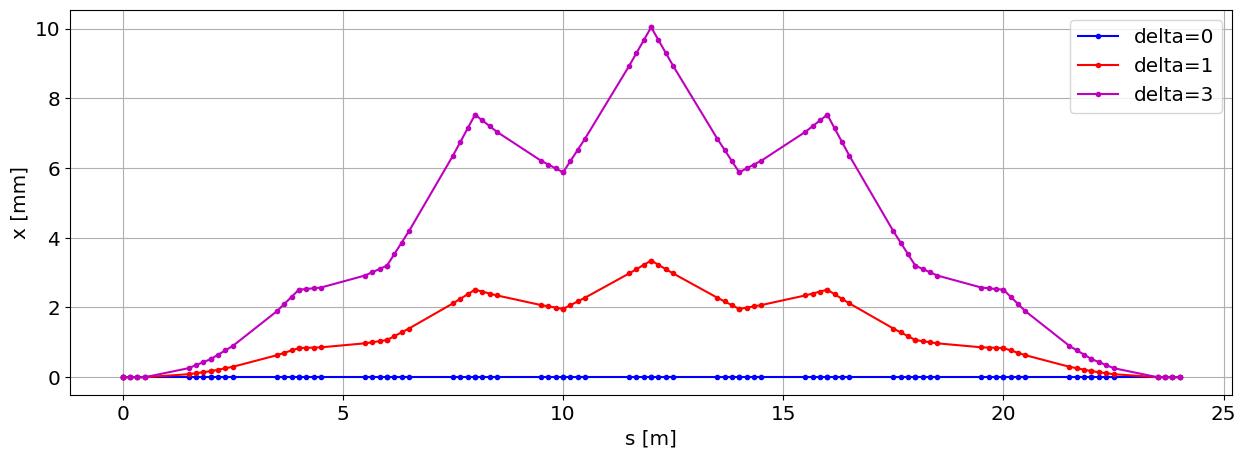

In [70]:
# tracking
for delta,color in zip([0,1, 3],['b','r','m']):
    beam = np.array([[0],[0],[delta]])
    transported_particles = transportParticles(beam, 6*fodo_lattice)
    plt.plot(transported_particles['s'], transported_particles['x'][0], '.-'+color, label=f'delta={delta}')

plt.legend()
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('x [mm]')

### Exercise 36
Work out the transverse components of the periodic beam matrix $\sigma_0$. Assume that the geometrical emittance is $\epsilon_0=10^{-6}$ m rad. Furthermore, assume that the momentum spread $\sigma_0(3,3)=\sigma_p^2$ is zero and plot the beam size along the beam line.

#### SOLUTION

In [71]:
epsilon_0 = 1e-6
sigma_p_2 = 0
sigma_0 = epsilon_0*np.array([[beta, -alpha, 0],[-alpha, gamma,0],[0,0,sigma_p_2]])

Text(0.5, 0, 's [m]')

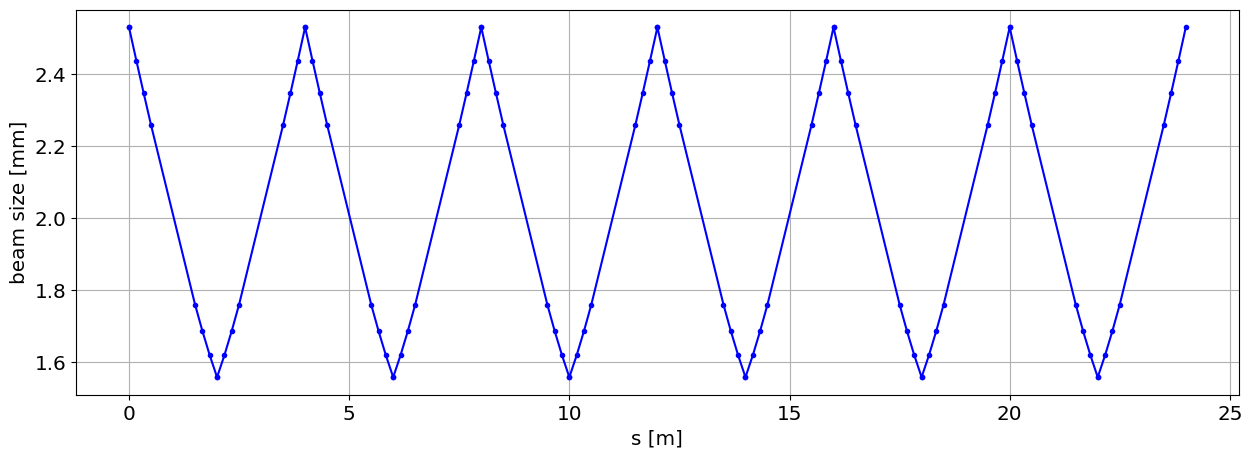

In [72]:
transported_sigmas = transportSigmas(sigma_0, 6*fodo_lattice)
plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma11']), '.-b')
plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')

### Exercise 37
Plot the beam size for for $\sigma_p^2=10^{-3}$ and for $\sigma_p^2=3\times 10^{-3}$. What happens if you change the phase advance of the cell? Try out by slightly changing the focal lengths.

#### SOLUTION

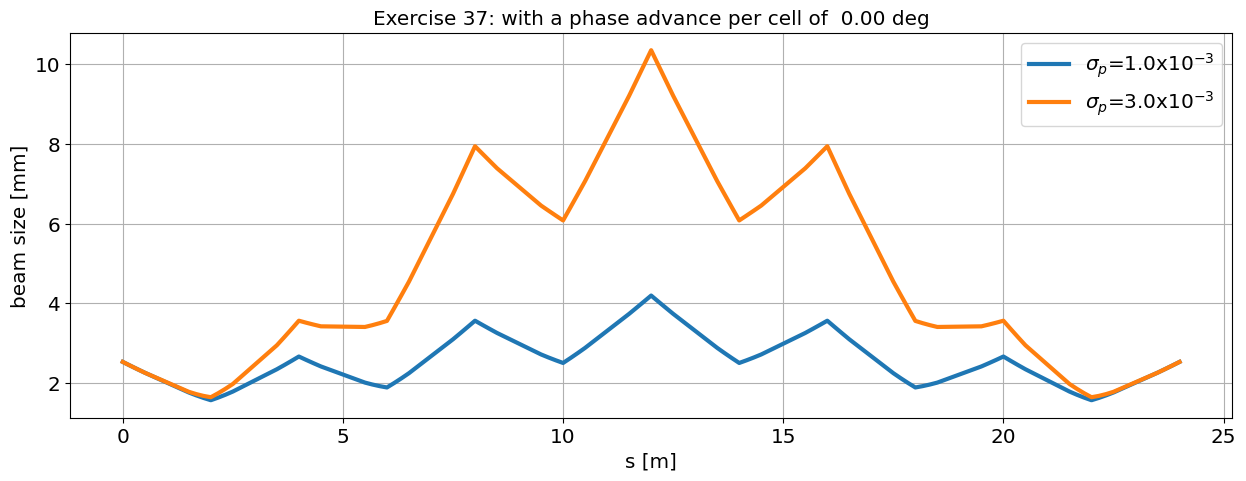

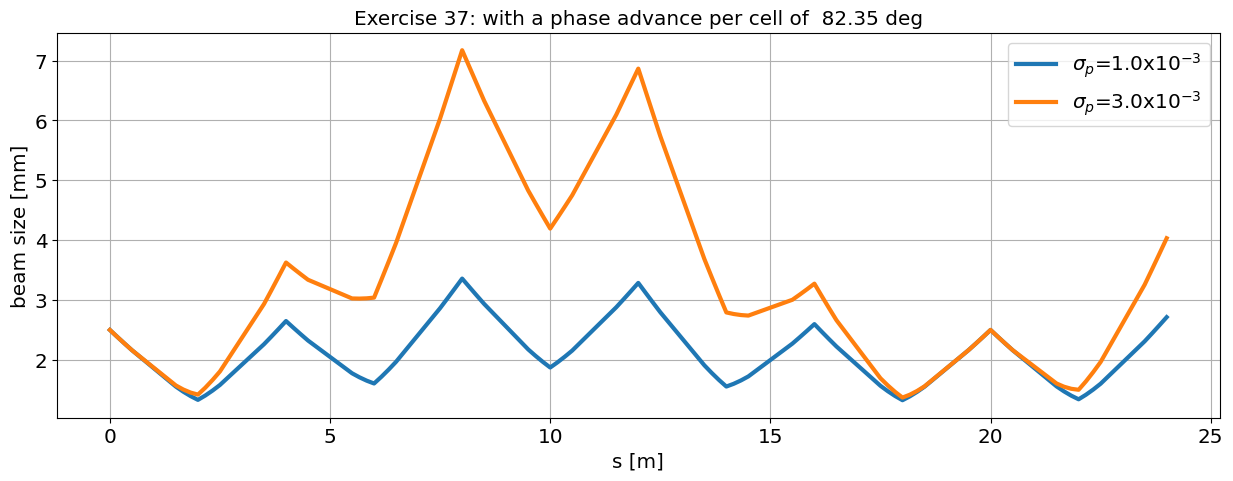

In [73]:
l_cell = 4
l_dipole = 1
l_drift = (l_cell-l_dipole*2)/4
phi = 20*pi/360

for f in [2.26085, 1.8]:
    plt.figure()
    fodo_lattice = Q3(f)+3*D3(l_drift/3)+B3(phi,l_dipole)+3*D3(l_drift/3)+Q3(-f)+3*D3(l_drift/3)+B3(phi,l_dipole)+3*D3(l_drift/3)
    beamline = 6*fodo_lattice
    tune, beta, alpha, gamma = twiss(beamline)
    
    for sigma_p in [1e-3, 3e-3]:
        sigma_p_2 = (sigma_p)**2
        sigma_0 = epsilon_0*np.array([[beta, -alpha, 0],[-alpha, gamma,0],[0,0,sigma_p_2/epsilon_0]])
        transported_sigmas = transportSigmas(sigma_0, 6*fodo_lattice)
        plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma11']), label= f'$\sigma_p$={sigma_p}x$10^{{-3}}$', lw=3)

    plt.grid(True)
    plt.ylabel('beam size [mm]')
    plt.xlabel('s [m]')
    plt.title(f'Exercise 37: with a phase advance per cell of {tune*2*180: 3.2f} deg')
    plt.legend(loc='best')

### Exercise 38

Determine the periodic dispersion at the start of the cell. Then plot the dispersion in the cell.

#### SOLUTION

For that we need to find the *real* periodic solution of the 3x3 one turn matrix

In [74]:
OTM = getEquivalentElement(beamline)
eigenvalues, eigenvectors =np.linalg.eig(OTM[0]['matrix'])
print(eigenvalues)
print(eigenvectors[:,2])

[0.13306447+0.99110738j 0.13306447-0.99110738j 1.        +0.j        ]
[0.75524936+0.j 0.20979149+0.j 0.62095567+0.j]


Note that the third eigenvalue is real, i.e. is associated to a real eigenvector, which is our solution:

In [75]:
myDispersion=np.real(eigenvectors[:,2]/eigenvectors[2,2])
print(myDispersion)

[1.21626937 0.3378526  1.        ]


Sanity check: one can see that indeeed is a periodic solution!

In [76]:
OTM[0]['matrix'] @ myDispersion

array([1.21626937, 0.3378526 , 1.        ])

And track it along our lattice:

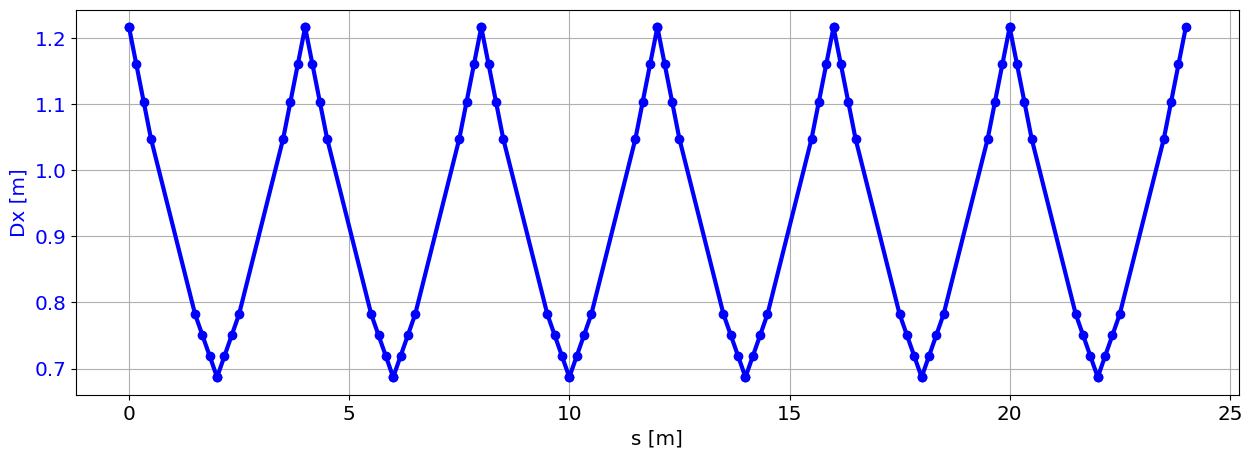

In [77]:
# need to make dispersion array compatible with our transportParticles function
myDispersion = np.reshape(myDispersion, (3,1))
transported_particles = transportParticles(myDispersion, beamline)

plt.plot(transported_particles['s'], transported_particles['x'][0], 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('Dx [m]', color='b')
plt.tick_params(axis='y', labelcolor='b')


### Exercise 39
Convert the code to use $4\times4$ matrices, where the third and fourth columns are associated with the vertical plane. 

#### SOLUTION

In [78]:
# The drift in 4D
D4 = lambda L: [{'matrix': np.array([[1, L, 0, 0],[0, 1, 0, 0], [0, 0, 1, L], [0, 0, 0, 1]]), 'length': L}]

# The quadrupole in 4D
Q4 = lambda f: [{'matrix': np.array([[1, 0, 0, 0],[-1/f, 1, 0, 0],[0, 0, 1, 0],[0, 0, 1/f, 1]]), 'length': 0}]

# The sector bend in 4D
B4 = lambda phi, l: [{'matrix': np.array([[np.cos(phi),l/phi*np.sin(phi), 0, 0],\
                               [-np.sin(phi)/l*phi, np.cos(phi), 0, 0],\
                               [0, 0, 1, l],
                               [0, 0, 0, 1]]),'length': l}]

def twiss(beamline):
    '''Returns the Q, and the Twiss parameters beta, alpha, gamma of the beamline'''
    # 2x2 case
    OTM = getEquivalentElement(beamline)
    R = OTM[0]['matrix']
    
    if np.shape(R)[0]<4:
        mu = np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu = 2*np.pi-mu
        Q = mu/(2*np.pi)
        beta = R[0,1]/np.sin(mu)
        alpha = (0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma = (1+alpha**2)/beta
        return Q, beta, alpha, gamma

    
    # 4x4 case, we assume uncoupled motion!!!
    if np.shape(R)[0]==4:
        Rx = R[:2,:2]
        mux = np.arccos(0.5*(Rx[0,0]+Rx[1,1]))
        if (Rx[0,1]<0): 
            mux = 2*np.pi-mux
        Qx = mux/(2*np.pi)
        betax = Rx[0,1]/np.sin(mux)
        alphax = (0.5*(Rx[0,0]-Rx[1,1]))/np.sin(mux)
        gammax = (1+alphax**2)/betax
        
        Ry = R[2:,2:]
        muy = np.arccos(0.5*(Ry[0,0]+Ry[1,1]))
        if (Ry[0,1]<0): 
            muy = 2*np.pi-muy
        Qy = muy/(2*np.pi)
        betay = Ry[0,1]/np.sin(muy)
        alphay = (0.5*(Ry[0,0]-Ry[1,1]))/np.sin(muy)
        gammay = (1+alphay**2)/betay
        
        return (Qx, betax, alphax, gammax, Qy, betay, alphay, gammay)
    
# Test
f = 2.
l_cell = 4
l_drift = (l_cell)/2
fodo_lattice = Q4(f) + 10*D4(l_drift/10) + Q4(-f) + 10*D4(l_drift/10)
twiss(fodo_lattice)
print(f'''
The tune is: {tune}
The beta is: {beta} m
The alpha is: {alpha} 
The gamma is: {gamma}
''')


The tune is: 0.2287591328904243
The beta is: 6.235264040046442 m
The alpha is: -1.7320177889017894 
The gamma is: 0.641494184589888



### Exercise 40
Start from a single FODO cell with 60 degrees/cell you used earlier. Insert sector bending magnets with a bending angle of $\phi=10\,$degrees in the center of the drift spaces. The bending magnets will spoil the phase advance in one plane. Now you have two phase advances and need to adjust both quadrupoles (by hand to 2 significant figures) such that it really is 60 degrees in both planes.

#### SOLUTION

In [79]:
l_cell = 4
l_dipole = 1
l_drift = (l_cell-l_dipole*2)/4
phi = 10*pi/360

def computeTunes(f_f,f_d):
    fodo_lattice = Q4(f_f) + D4(l_drift) + B4(phi,l_dipole) + D4(l_drift) + Q4(f_d) + D4(l_drift) + B4(phi,l_dipole) + D4(l_drift)
    Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = twiss(fodo_lattice)
    print(f'Qx = {Qx}')
    print(f'Qy = {Qy}')
    print(f'f_f = {f_f}')
    print(f'f_d = {f_d}')

    
interactive_plot = interactive(computeTunes, f_f=(1.9,2.1,.001), f_d=(-2.1,-1.9,.001), continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '100px'
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='f_f', max=2.1, min=1.9, step=0.001), FloatSlider(val…

In [80]:
computeTunes(2.04,-2.012)

Qx = 0.16679597540775903
Qy = 0.16683496767875342
f_f = 2.04
f_d = -2.012


### Exercise 41

Use the result from exercise 40 and adjust the two quadrupoles such that the phase advance in the horizontal plane is 90 degrees, cell, while it remains 60 degrees/cell in the vertical plane. 

#### SOLUTION

In [81]:
interactive_plot = interactive(computeTunes,f_f=(1.,3,.001),f_d=(-3,-1,.001),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '100px'
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='f_f', max=3.0, min=1.0, step=0.001), FloatSlider(val…

In [82]:
computeTunes(1.491,-1.814)

Qx = 0.25013216769227664
Qy = 0.16677964050295388
f_f = 1.491
f_d = -1.814


### Exercise 42
Prepare a beam line with eight FODO cells without bending magnets and with 60 degrees/cell phase advance in both planes. (a) Prepare the periodic beam  matrix sigma0 (4x4, uncoupled) as the initial beam and plot both beam sizes along the beam line. (b) Use sigma0 as the starting beam, but change the focal length of the second quadrupole by 10\% and plot the beam sizes once again. Discuss you observations.

#### SOLUTION

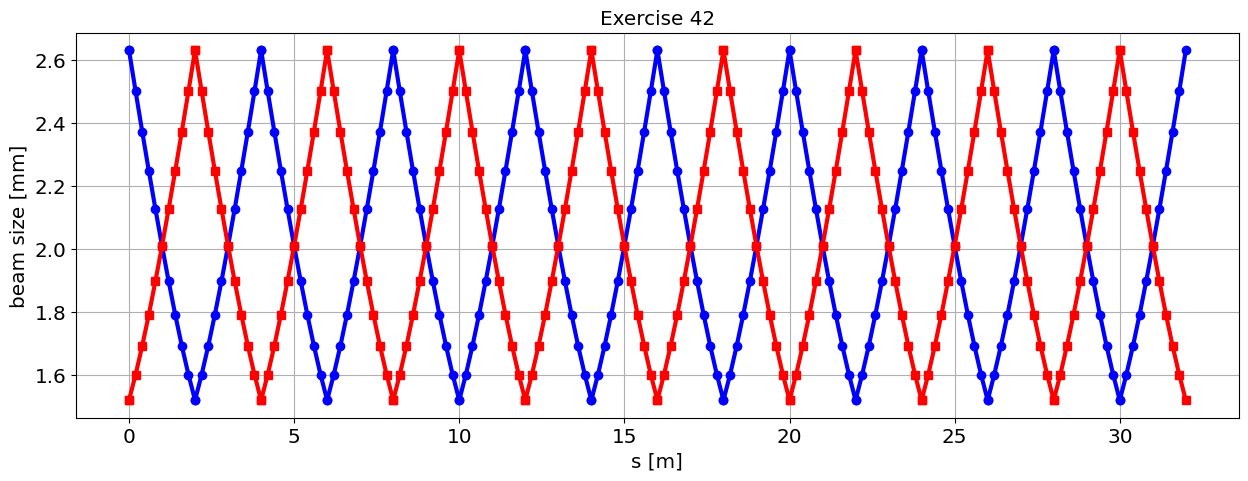

In [83]:
def transportSigmas4D(sigma, beamline):
    coords = [sigma]
    s = [0]
    for element in beamline:
        coords.append(element['matrix'] @ coords[-1] @ element['matrix'].transpose())
        s.append(s[-1] + element['length']) 
    coords = np.array(coords)
    s = np.array(s)
    if len(sigma) < 4:
        return {'sigma11': coords[0][0],
                'sigma12': coords[0][1],
                'sigma21': coords[1][0], # equal to sigma12
                'sigma22': coords[1][1],
                's': s,
                'coords': coords,}
    elif len(sigma)==4:
        return {'sigma11': coords[0][0],
                'sigma12': coords[0][1],
                'sigma21': coords[1][0], # equal to sigma12
                'sigma22': coords[1][1],
                'sigma33': coords[2][2],
                'sigma34': coords[2][3],
                'sigma43': coords[3][2], # equal to sigma34
                'sigma44': coords[3][3],
                's': s,
                'coords': coords,}
        
f = 2.
l_cell = 4
l_drift = (l_cell)/2
fodo_lattice = Q4(f) + 10*D4(l_drift/10) + Q4(-f) + 10*D4(l_drift/10)
beamline = 8*fodo_lattice

Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = twiss(beamline)


epsilon_0 = 1e-6
sigma_0 = epsilon_0*np.array([[betax, -alphax,0, 0],[-alphax, gammax,0,0],
                  [0,0, betay, -alphay],[0,0, -alphay, gammay],
                 ])

transported_sigmas = transportSigmas4D(sigma_0, beamline)
plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma11']), 'o-b', lw=3)
plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma33']), 's-r', lw=3)
plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')
plt.title('Exercise 42');

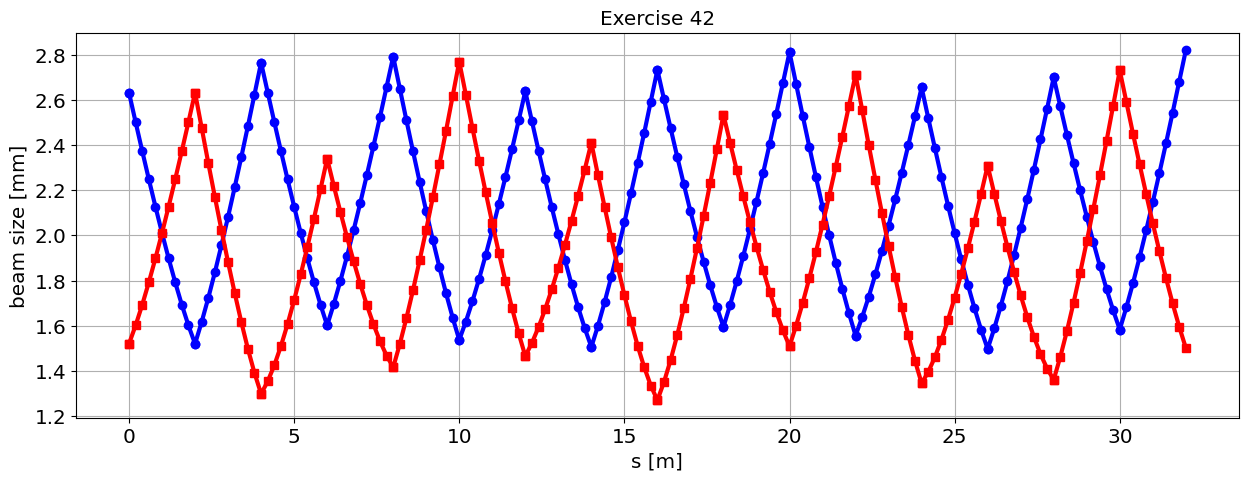

In [84]:
from copy import deepcopy
beamline_new = deepcopy(beamline)
beamline_new[11]['matrix'][1,0] = beamline_new[11]['matrix'][1,0]*1.1
beamline_new[11]['matrix'][3,2] = beamline_new[11]['matrix'][3,2]*1.1

Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = twiss(fodo_lattice)

epsilon_0 = 1e-6
sigma_0 = epsilon_0*np.array([[betax, -alphax,0, 0],[-alphax, gammax,0,0],
                  [0,0, betay, -alphay],[0,0, -alphay, gammay],
                 ])

transported_sigmas = transportSigmas4D(sigma_0, beamline_new)
plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma11']), 'o-b', lw=3)
plt.plot(transported_sigmas['s'], np.sqrt(transported_sigmas['sigma33']), 's-r', lw=3)
plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')
plt.title('Exercise 42');

### Exercise 43
From the lecture about betatron coupling identify the transfer matrix for a solenoid and write a function that receives the longitudinal magnetic field $B_s$ and the length of the solenoid as input and returns the transfer matrix.  Then extend the simulation code to handle solenoids. Finally, define a beam line where you place the solenoid in the middle of a FODO cell and follow a particle with initial condition $(x_0,x'_0,y_0,y'_0)=(10^{-3}\,\mathrm{m},0,0,0).$ What do you observe? Is the motion confined to the horizontal plane? 

#### SOLUTION
One has to remember that the matrix is
\begin{equation}
M_{\text {SOLENOID}}=\left(\begin{array}{cccc}{C^{2}} & {\frac{1}{K} S C} & {S C} & {\frac{1}{K} S^{2}}\\
{-K S C} & {C^{2}} & {-K S^{2}} & {S C}\\
{-S C} & {-\frac{1}{K} S^{2}} & {C^{2}} & {\frac{1}{K} S C}\\
{K S^{2}} & {-S C} & {-K S C} & {C^{2}}
\end{array}\right)
\end{equation}
where
\begin{equation}
K=\operatorname{sgn}(\mathrm{q}) \frac{B_{s}}{2(B \rho)}
\end{equation}
and
\begin{equation}
\begin{array}{l}{C=\cos K L} \\ {S=\sin K L}\end{array}
\end{equation}

In [85]:
def solenoid(Bs, L, B_rho, q):
    '''Returns the L-long solenoid element with field Bs 
    normalized to B_rho and to the q polarity.'''
    K = np.sign(q)*Bs/B_rho/2
    C = np.cos(K*L)
    S = np.sin(K*L)
    matrix = np.array([[C**2, S*C/K, S*C, S**2/K],
                     [-K*S*C, C**2, -K*S**2, S*C],
                     [-S*C, -S**2/K, C**2, S*C/K],
                     [K*S**2, -S*C, -K*S*C, C**2]])
    return [{'matrix': matrix,'length': L}]

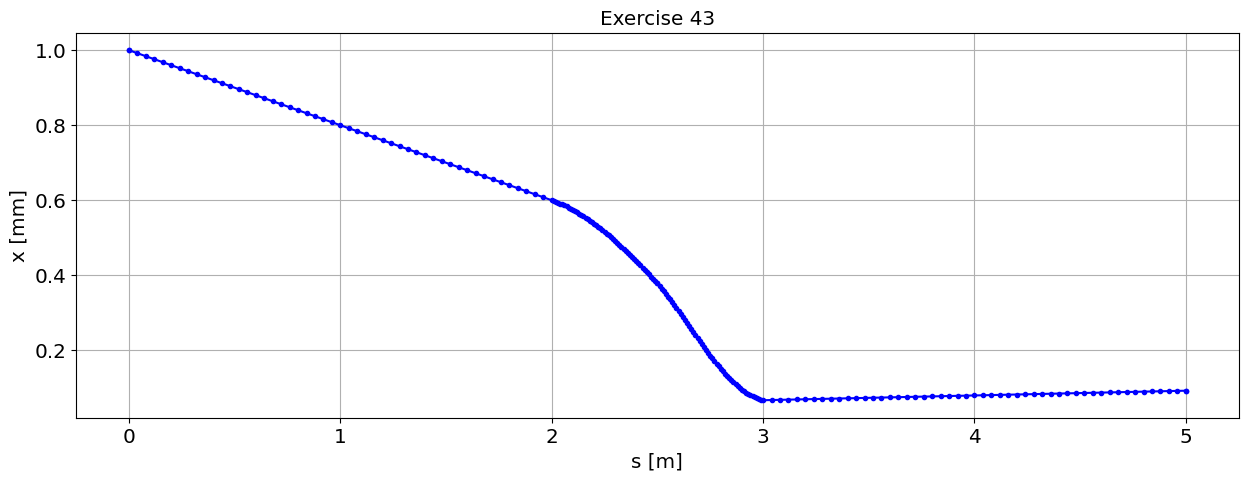

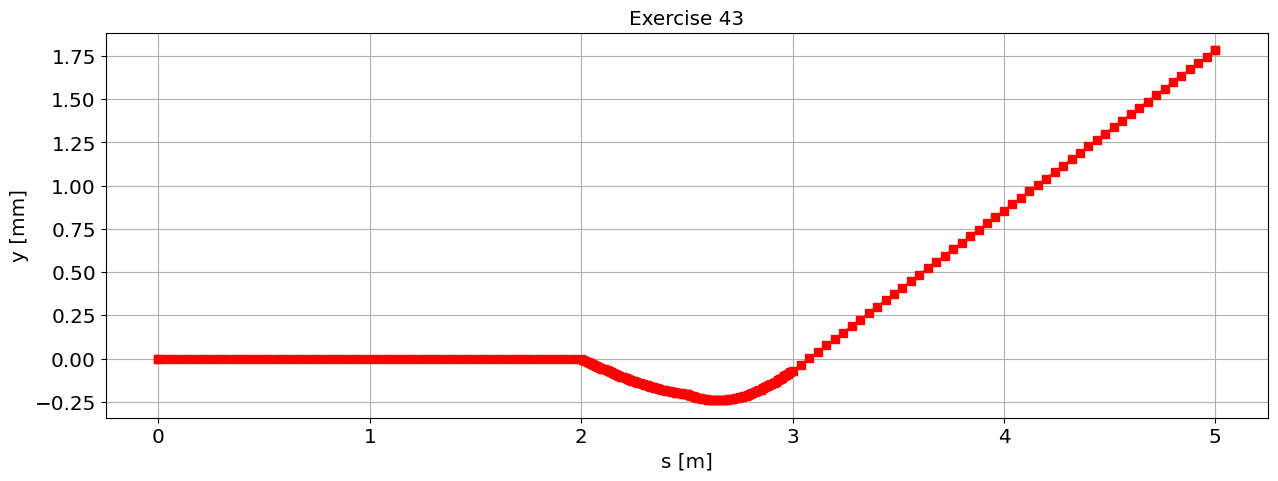

In [86]:
# we need a minor update to the transportParticles
def transportParticles4D(x0,beamline):
    coords = [x0]
    s = [0]
    for elements in beamline:
        coords.append(elements['matrix'] @ coords[-1])
        s.append(s[-1] + elements['length']) 
    coords = np.array(coords).transpose()
    if len(x0)<4:
        return {'x':  coords[:,0,:],
            'xp': coords[:,1,:],
            's':  np.array(s),
            'coords': coords,}
    elif len(x0)==4:
        return {'x':  coords[:,0,:], # [particle_idx, s_idx]
            'xp': coords[:,1,:],     # [particle_idx, s_idx]
            'y':  coords[:,2,:],     # [particle_idx, s_idx]
            'py': coords[:,3,:],     # [particle_idx, s_idx]
            's':  np.array(s),       # [s_idx]
            'coords': coords,}       # [particle_idx, coord_idx, s_idx]

f = 2.5
L_2 = 2
fodo_lattice = Q4(2*f) + 50*D4(L_2/50) + 50*solenoid(.2,.01,.1,1) + Q4(-f) + 50*solenoid(.4,.01,.1,1) + 50*D4(L_2/(50))+Q4(2*f)

beam = np.array([[1],[0],[0],[0]])

output = transportParticles4D(beam, fodo_lattice)

plt.plot(transported_particles['s'], transported_particles['x'][0],'.-b')
plt.xlabel('s [m]')
plt.ylabel("x [mm]")
plt.grid(True)
plt.title('Exercise 43')

plt.figure()
plt.plot(transported_particles['s'], transported_particles['y'][0],'s-r')
plt.xlabel('s [m]')
plt.ylabel("y [mm]")
plt.grid(True)
plt.title('Exercise 43');

One can clearly see that the motion is coupled between the two transverse planes.

---
## Well done! You did all exercises!

Now keep going and explore other concepts that you have encountered during the lectures!

---